# Data Cleaning

## Python Setup

In [1]:
# %run doc2vec_launcher
# import doc2vec_launcher
# import collections
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import pandas as pd
import numpy as np
import math
import re
from collections import OrderedDict
import random

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [2]:
# nltk.download('stopwords')

## Data Read-In and Corpus Creation

In [3]:
un_speeches = pd.read_csv('../data/un_speeches.csv')

In [4]:
countries = list(un_speeches['country'].values)

In [5]:
un_speeches.head()

,country,speech
0,Afghanistan,"Mr. President, Distinguished Heads of State an..."
1,Albania,"Mr. President, Ladies and Gentlemen,\nHow many..."
2,Angola,Statement by the RepuNic of Angola 72n Session...
3,Antigua_and_Barbuda,"Mr President, Mr Secretary-General, Distinguis..."
4,Armenia,Distinguished President of the General Assembl...


In [6]:
un_speeches.shape

(138, 2)

## Text Cleaning and Processing

In [7]:
stemmer = nltk.stem.SnowballStemmer('english')

In [8]:
stop_words = stopwords.words('english')
stop_words += ['nation', 'mr', 'presid', 'becaus', 'also', 'u', 'unit', 'intern', 'un', 'peopl']
stop_words += ['na', 'general', 'state', 'world', 'countri', 'peac', 'develop', 'must', 'h', 'e', 'us']
stop_words += ['would']

In [9]:
def create_bag_of_words(corpus, ngram_range = (1, 1)
                        , stop_words = stop_words, stemmer = stemmer
                        , min_df = 1, max_df = 1.0):

    # Clean corpus
    corpus = np.array([re.sub(r'\W+|\d+', ' ', text).lower() for text in corpus])
    corpus = np.array([re.sub('_+', ' ', text) for text in corpus])
    
    tokenize = lambda x: [stemmer.stem(i) for i in x.split()]
    vectorizer = CountVectorizer(analyzer="word" #unit of features are single words rather then phrases of words 
                                 , tokenizer=tokenize
                                 , ngram_range=ngram_range
                                 , stop_words = stop_words
                                 , strip_accents='unicode'
                                 , min_df = min_df
                                 , max_df = max_df)
    
    bag_of_words = vectorizer.fit_transform(corpus) #transform our corpus is a bag of words 
    features = vectorizer.get_feature_names()
    
    return bag_of_words, features

In [10]:
def get_word_counts(bag_of_words, feature_names):
    
    np_bag_of_words = bag_of_words.toarray() # convert bag of words to array
    word_count = np.sum(np_bag_of_words,axis=0) # calculate word count
    np_word_count = np.asarray(word_count).ravel()  # convert to flattened array.
    
    # create dict of words mapped to count of occurrences of each word.
    dict_word_counts = dict( zip(feature_names, np_word_count) )
    
    # Create ordered dictionary
    orddict_word_counts = OrderedDict( sorted(dict_word_counts.items(), key=lambda x: x[1], reverse=True), )
    
    return orddict_word_counts

## Summary Statistics

In [11]:
corpus = un_speeches['speech'].values

In [12]:
bag_of_words, features = create_bag_of_words(corpus)
word_count = get_word_counts(bag_of_words, features)

In [13]:
# Top words overall
pd.Series(word_count).head(10)

secur      967
global     792
human      764
support    707
sustain    707
right      697
year       693
govern     570
region     562
need       558
dtype: int64

## Comparison Example of USA and France:

In [14]:
# Use the correct spelling of state in data
country1 = "United_States_of_America"
country2 = "France"

In [15]:
un_speeches_subset = un_speeches[un_speeches['country'].isin([country1, country2])].reset_index()
corpus_subset = un_speeches_subset['speech'].values
country1 = un_speeches_subset['country'][0]
country2 = un_speeches_subset['country'][1]

In [16]:
bag_of_words, features = create_bag_of_words(corpus_subset)
d = {'word' : np.asarray(features)
     , 'country1': bag_of_words.toarray()[0]
     , 'country2': bag_of_words.toarray()[1]}
df = pd.DataFrame(data = d)

Text(0,0.5,'Word Frequency United_States_of_America')

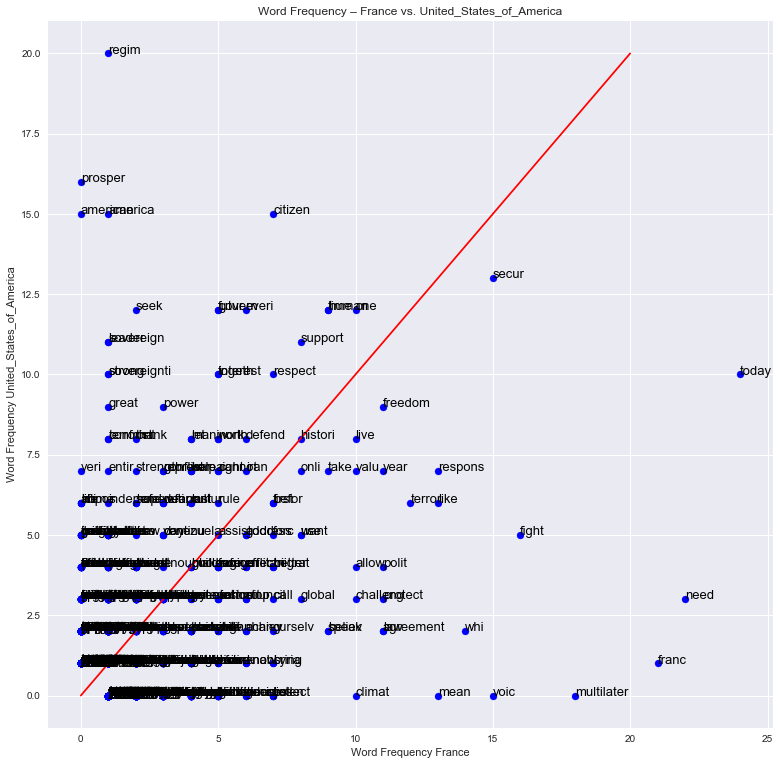

In [17]:
x_plot = df['country1']
y_plot = df['country2']
labels_plot = df['word']

max_count = max(max(x_plot), max(y_plot))
min_max = min(max(x_plot), max(y_plot))

fig, ax = plt.subplots(1, 1, figsize = (13,13))
plt.scatter(x_plot, y_plot, color='blue')
plt.plot([0, min_max], [0, min_max], '-', color = 'red')

for i, j, k in zip(x_plot, y_plot, labels_plot):
    ax.annotate('%s' %k, xy = (i,j), fontsize = 13, color = 'black');

ax.set_title('Word Frequency – {} vs. {}'.format(country1, country2))
plt.xlabel('Word Frequency {}'.format(country1))
plt.ylabel('Word Frequency {}'.format(country2))

## Latent Dirichlet Allocation Topic Modeling

In [18]:
def create_topics(words, features, n_components = 3, n_top_words = 5):
    i=0
    lda = LatentDirichletAllocation(n_components = n_components, learning_method = 'online', random_state=1)
    i+=1
    doctopic = lda.fit_transform(words)
    i+=1

    ls_keywords = []
    for i,topic in enumerate(lda.components_):
        word_idx = np.argsort(topic)[::-1][:n_top_words]
        keywords = ', '.join( features[i] for i in word_idx)
        ls_keywords.append(keywords)
        print(i, keywords)
        i+=1
            
    return ls_keywords, doctopic

In [19]:
corpus = un_speeches['speech'].values

In [20]:
corpus_bag_of_words, corpus_features = create_bag_of_words(corpus, ngram_range=(1, 3)
                                                           , min_df = 0.05, max_df = 0.95)

In [21]:
# Simple LDA Model
simple_keywords, simple_corpus_doctopic = create_topics(corpus_bag_of_words, corpus_features)

0 secur, sustain, climat, chang, govern
1 north, korea, whi, korean, onli
2 secur, human, region, right, global


In [22]:
# After further Analysis, this distribution seems most relevant
ls_corpus_keywords, corpus_doctopic = create_topics(corpus_bag_of_words, corpus_features
                                                    , n_components= 13, n_top_words = 12)

0 secur, sustain, human, global, govern, effort, new, commit, need, right, chang, conflict
1 korea, north, north korea, republ korea, japan, korean, dialogu, nuclear, missil, republ, six, north korean
2 region, human, secur, terror, stabil, right, effort, continu, polit, arab, achiev, terrorist
3 secur, global, human, govern, sustain, communiti, region, effort, right, chang, commit, continu
4 work, global, sustain, human, right, secur, govern, need, commit, challeng, implement, new
5 island, pacif, ocean, climat, climat chang, chang, need, fiji, action, region, new, small
6 secur, human, global, sustain, effort, chang, continu, econom, right, govern, implement, need
7 ukrain, right, sustain, secur, human, russia, human right, island, global, assembl, time, communiti
8 chad, lake, sustain, right, secur, govern, global, climat, continu, make, work, communiti
9 secur, global, time, challeng, chang, sustain, govern, continu, effort, human, climat, reform
10 global, secur, sustain, region, 

### Topic Interpretation

Which topics seem to make sense?
- **Topic 1: North Korea** (`north korea`, `republ korea`, `japan`, `nuclear`, `missil`)
- **Topic 2: Arab Region and Terrorism** (`terror`, `arab`, `stabil`)
- **Topic 5: Climat Change** (`island`, `pacif`, `ocean`, `climat chang`, `action`)
- **Topic 7: Ukrain, Russia, and Human Rights** (`ukrain`, `russia`, `human right`)

In [23]:
# Replace this with Relevant Topic Numbers
relevant_topics = [1, 2, 5, 7]

### Assigning a Dominant Topic

Overall, and among the topics that "make sense", which is the dominant topic for each speech?

In [24]:
# Overall Dominant Topic
df = pd.DataFrame(data = corpus_doctopic)
dom_topic = np.asarray(df.idxmax(axis=1))
dom_topic_pct = np.asarray(df.max(axis = 1))

In [25]:
# Dominant Topic among relevant Topics
relevant_corpus_doctopic = corpus_doctopic[:, relevant_topics]
df = pd.DataFrame(data = relevant_corpus_doctopic)
relevant_dom_topic = np.asarray(df.idxmax(axis=1))
mapping = np.vectorize(lambda t: relevant_topics[t])
relevant_dom_topic = mapping(relevant_dom_topic)
relevant_dom_topic_pct = np.asarray(df.max(axis = 1))

In [26]:
dom_topics = pd.DataFrame({'country': np.asarray(countries)
                           , 'dom_topic': dom_topic
                           , 'dom_topic_pct': dom_topic_pct
                           , 'relevant_dom_topic': relevant_dom_topic
                           , 'relevant_dom_topic_pct': relevant_dom_topic_pct})

**Which Countries are most preoccupied with North Korea?**

In [27]:
dom_topics[dom_topics['relevant_dom_topic']==1]

,country,dom_topic,dom_topic_pct,relevant_dom_topic,relevant_dom_topic_pct
56,Japan,9,0.603156,1,0.348025
93,Republic_of_Korea,9,0.771108,1,0.150016
128,Uganda,9,0.997013,1,0.000249


**Which Countries are most preoccupied with Climate Change?**

In [28]:
dom_topics[dom_topics['relevant_dom_topic']==5]

,country,dom_topic,dom_topic_pct,relevant_dom_topic,relevant_dom_topic_pct
29,Dominica,5,0.603731,5,0.603731
36,Fiji,9,0.605588,5,0.358389
72,Micronesia_(Federated_States_of),9,0.464964,5,0.354228
80,New_Zealand,9,0.584581,5,0.154612
86,Papua_New_Guinea,9,0.740563,5,0.216493


### Topic Breakup in a Speech

Let's see how well each topic they explains the speech of a given country.

In [29]:
country = "Japan"

In [30]:
for i in range(corpus_doctopic.shape[1]):
    print("Topic {}: {:.0%}".format(i, corpus_doctopic[countries.index(country)][i]))

Topic 0: 0%
Topic 1: 35%
Topic 2: 4%
Topic 3: 0%
Topic 4: 0%
Topic 5: 0%
Topic 6: 0%
Topic 7: 1%
Topic 8: 0%
Topic 9: 60%
Topic 10: 0%
Topic 11: 0%
Topic 12: 0%


## Word2Vec Analysis (preliminary)

In [31]:
# n_words =10000
# list_of_speeches = list() 
# count = collections.Counter()
# for i, country in enumerate(countries):
#     with open('../input/clean_data/{}.txt'.format(country), 'r') as myfile:
#         speech=myfile.read().replace('\n', ' ')
#     speech = speech.lower()
#     speech = re.sub('[^a-z]', ' ', speech)
#     wordlist = speech.split()
#     wordlist = removeStopwords(wordlist=wordlist, stopwords = stopwords)
#     count.update(wordlist)
#     list_of_speeches.append(wordlist)

# dictionary = dict()
# vocabulary_size = 0
# for word in count:
#     dictionary[word] = len(dictionary)
#     vocabulary_size += 1
    
# list_of_speeches_changed = list()

# for i, speech in enumerate(list_of_speeches):
#     sub_list = list()
#     for word in speech:
#         index = dictionary.get(word, 0)
#         sub_list.append(index)
#     list_of_speeches_changed.append(sub_list)

#     reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))


# word_embeddings, doc2vec_embeddings = doc2vec_training(list_of_speeches_changed, vocabulary_size, 30)
# print(word_embeddings[0])